In [73]:
%load_ext autoreload
%autoreload 2

from IPython.display import display


import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull_amp as ppamp

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Synthetic Data

In [101]:
vWS, vES, kWSp, kESu, kSp, kSu = 2.0, 1.0, 1.0, 1.0, 10, 10

vWSp = kWSp/kESu
vSp = kSp/kESu
vSu = kSu/kESu

print(vWS, vES, vWSp, vSp, vSu)

n_samples = 100000

WT = 10**np.random.normal(2.5, 0.5, size=n_samples)
ET = 10**np.random.normal(2.5, 0.5, size=n_samples)
ST = 10**np.random.normal(2.5, 0.5, size=n_samples)

pushpull = ppamp.PushPull()
pushpull.set_data(WT, ET, ST, np.array([]))
 
SpT_true = pushpull.predict_all(np.array([vWS, vES, vWSp, vSp, vSu]))
  
SpT_noise = np.zeros_like(SpT_true)
for i, SpT in enumerate(SpT_true):
    SpT_noise[i] = 10**np.random.normal(np.log10(SpT), np.sqrt(0.5))
    

df_syn = pd.DataFrame(np.c_[WT, ET, ST, SpT_true, SpT_noise], columns=['WT', 'ET', 'ST', 'SpT_true', 'SpT_noise'])

df_syn['WT/ET'] = df_syn['WT'] / df_syn['ET']
df_syn['SpT_true/ST'] = df_syn['SpT_true'] / df_syn['ST']
df_syn['SpT_noise/ST'] = df_syn['SpT_noise'] / df_syn['ST']

display(df_syn)

2.0 1.0 1.0 10.0 10.0


,WT,ET,ST,SpT_true,SpT_noise,WT/ET,SpT_true/ST,SpT_noise/ST
0,266.858139,283.672492,310.836401,156.296537,107.932115,0.940726,0.502826,0.347231
1,87.517654,175.034830,1012.651256,504.169979,1311.811334,0.500001,0.497871,1.295423
2,505.343100,65.619244,1739.123508,880.373457,272.913662,7.701142,0.506217,0.156926
3,413.150321,46.967388,3014.862849,1516.515135,1175.816045,8.796536,0.503013,0.390006
4,127.345603,1259.309735,71.905828,34.795616,45.186297,0.101123,0.483905,0.628409
...,...,...,...,...,...,...,...,...
99995,187.647579,68.179306,194.963629,99.955187,402.215033,2.752266,0.512686,2.063026
99996,1119.569349,1188.822666,281.131512,142.361456,23.098570,0.941746,0.506387,0.082163
99997,714.341529,854.990420,100.721172,50.912727,421.369976,0.835497,0.505482,4.183529
99998,41.413458,446.434009,258.999576,124.697733,905.875123,0.092765,0.481459,3.497593


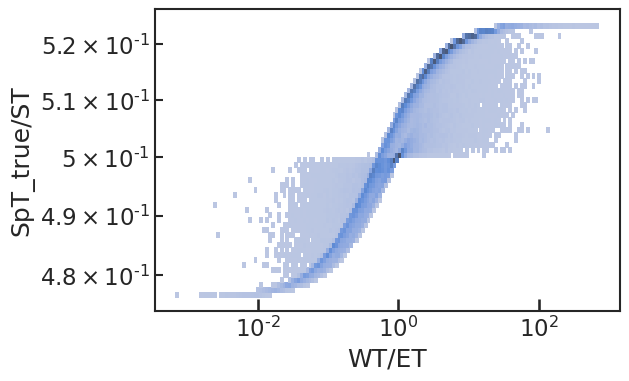

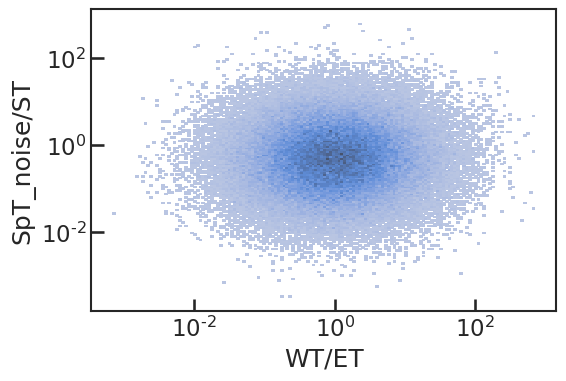

In [102]:
sns.histplot(df_syn, x='WT/ET', y='SpT_true/ST', log_scale=(True, True))

plt.show()


sns.histplot(df_syn, x='WT/ET', y='SpT_noise/ST', log_scale=(True, True))

plt.show()

# ax = sns.scatterplot(df_syn, x='WT/ET', y='SpT_noise/ST')

# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.show()



In [113]:
start = time.time()

pushpull = ppamp.PushPull()

pushpull.set_data(df_syn['WT'].values.copy(), df_syn['ET'].values.copy(), df_syn['ST'].values.copy(), df_syn['SpT_noise'].values.copy())

def cpp_loss(x, args):
    
    (vWS, vES, vWSp, vSp, vSu) = x
    (pushpull) = args
    
    loss = pushpull.loss(np.array([vWS, vES, vWSp, vSp, vSu]))

    return loss

x0 = (1.0, 1.0, 1.0, 1.0, 1.0)
# x0 = (1.0, 1.0, 1.0, 1e-3, 1e-3)
bounds = ((1e-6, None), (1e-6, None), (1e-6, None), (0.0, None), (0.0, None))

print("Initial Loss:", cpp_loss(x0, (pushpull)))


res = opt.minimize(cpp_loss, x0, args=(pushpull,), method='L-BFGS-B', jac='3-point', bounds=bounds, options={'iprint':101, 'eps': 1e-8, 'gtol': 1e-8, 'ftol':1e-16})

# res = opt.minimize(cpp_loss, x0, args=(pushpull,), method='CG')


params = res.x


print("Final Loss:", res.fun)

end = time.time()

print("Time Elapsed", end-start, "seconds")

print(res)

Initial Loss: 0.5053175992258488
Final Loss: 0.5003855105914573
Time Elapsed 28.943920612335205 seconds
      fun: 0.5003855105914573
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.04465185e-09,  3.07944132e-10,  2.61573637e-09, -3.36534392e-09,
        3.10916688e-09])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 407
      nit: 35
     njev: 37
   status: 0
  success: True
        x: array([ 3.79301435,  2.67919343,  2.17285733, 17.45526886, 17.84679083])


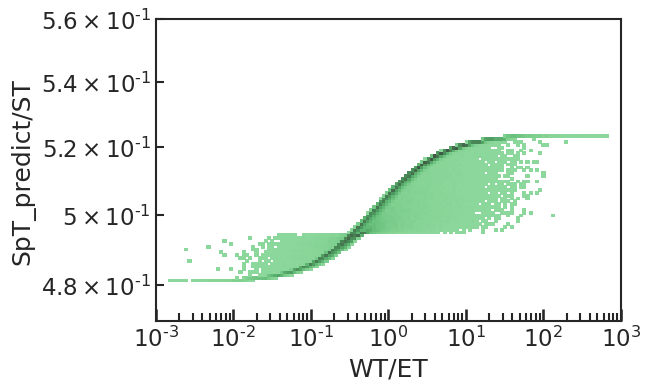

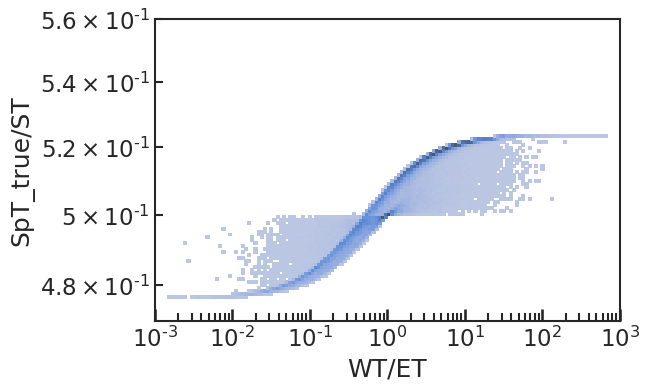

In [112]:
df_syn['SpT_predict'] = pushpull.predict_all(res.x)
# df_syn['SpT_predict'] = pushpull.predict_all(np.array((1, 1, 1.0, 1e-3, 1e-3)))
df_syn['SpT_predict/ST'] = df_syn['SpT_predict'] / df_syn['ST']

ax = sns.histplot(df_syn, x='WT/ET', y='SpT_predict/ST', log_scale=(True, True), color='g')
ax.set_xlim(1e-3, 1e3)
ax.set_ylim(4.7e-1, 5.6e-1)
plt.show()

ax = sns.histplot(df_syn, x='WT/ET', y='SpT_true/ST', log_scale=(True, True))
ax.set_xlim(1e-3, 1e3)
ax.set_ylim(4.7e-1, 5.6e-1)
plt.show()


# Real Data

In [60]:
start = time.time()


df = pd.read_csv("../data/Kinase_Phosphatase.csv")
df = df[(df[df.columns] >= 0).all(axis=1)]


df['WT/ET'] = df['Kinase'] / df['Phosphatase']
df['SpT/ST'] = df['Phosphorylation'] / df['Substrate']


display(df)

df_sample = df.sample(frac=0.5, random_state=776)

print(len(df_sample.index), "/", len(df.index))


pushpull = ppamp.PushPull()
pushpull.set_data(df_sample['Kinase'].values, df_sample['Phosphatase'].values, df_sample['Substrate'].values, df_sample['Phosphorylation'].values)
pushpull.set_hyperparams(np.array([0.2]))


def cpp_loss(x, args):
    
    (vWS, vES, vWSp, vSp, vSu) = x
    (pushpull) = args
    
    loss = pushpull.loss(np.array([vWS, vES, vWSp, vSp, vSu]))

    return loss

# x0 = (1.0, 1.0, 1.0, 1.0, 1.0)
x0 = (1e3, 1e3, 1.0, 1e-3, 1e-3)
# rand.seed(0)

# x0 = rand.random(5)
# print(x0)
bounds = ((1e-6, None), (1e-6, None), (1e-6, None), (0.0, None), (0.0, None))

print("Initial Loss:", cpp_loss(x0, (pushpull)))


res = opt.minimize(cpp_loss, x0, args=(pushpull,), method='L-BFGS-B', jac='2-point', bounds=bounds, options={'iprint':101, 'eps': 1e-8, 'gtol': 1e-8, 'ftol':1e-8})

params = res.x


print("Final Loss:", res.fun)

end = time.time()

print("Time Elapsed", end-start, "seconds")

print(res)

,Phosphatase,Kinase,Substrate,Phosphorylation,WT/ET,SpT/ST
0,3297.021729,96.710785,1068.271851,71.500488,0.029333,0.066931
1,1515.914673,1098.445068,502.736511,1673.208130,0.724609,3.328201
2,1500.352173,3507.595947,1605.011475,1411.279541,2.337848,0.879296
5,3474.466309,1498.413818,3547.943115,1589.457520,0.431264,0.447994
6,3134.303955,1329.153564,1962.470215,1691.346436,0.424067,0.861846
...,...,...,...,...,...,...
12739,2076.926270,1221.198853,943.772461,3179.493652,0.587984,3.368920
12740,5969.255859,198.256714,3328.473389,74.666458,0.033213,0.022433
12741,1115.785400,103.115700,355.451111,73.871040,0.092415,0.207823
12742,12431.415040,252.288696,5789.318848,113.409416,0.020294,0.019589


5995 / 11990
Initial Loss: 0.37688990739691985
Final Loss: 0.2747994181270011
Time Elapsed 3.0315499305725098 seconds
      fun: 0.2747994181270011
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.13137792e-12,  2.44379044e-06, -1.06705044e-12,  1.94165717e-11,
        1.05570265e-12])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 708
      nit: 65
     njev: 118
   status: 0
  success: True
        x: array([1.15244569e+05, 1.28379393e-03, 2.07377492e+06, 1.63082176e+04,
       1.75730787e+06])


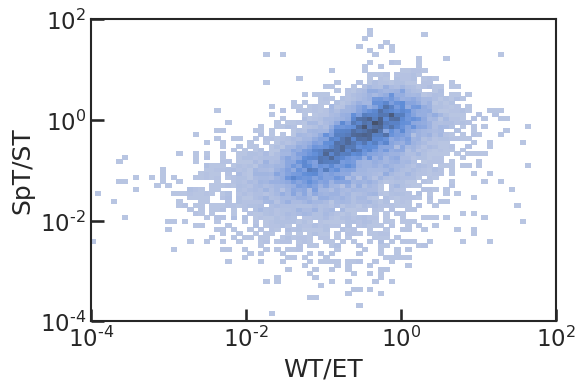

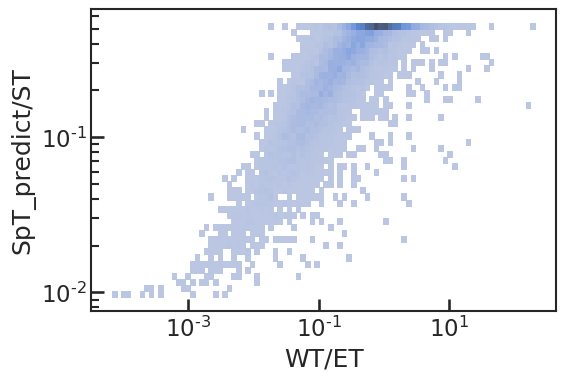

In [61]:
pushpull.set_data(df['Kinase'].values, df['Phosphatase'].values, df['Substrate'].values, df['Phosphorylation'].values)

df['SpT_predict'] = pushpull.predict_all(res.x)
df['SpT_predict/ST'] = df['SpT_predict'] / df['Substrate']


ax = sns.histplot(df, x='WT/ET', y='SpT/ST', log_scale=(True, True))
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(1e-4, 1e2)
plt.show()


sns.histplot(df, x='WT/ET', y='SpT_predict/ST', log_scale=(True, True))

plt.show()

# df['SpT_noise'] = 0.0
# for index, row in df.iterrows():
#     df.loc[index, 'SpT_noise'] = 10**np.random.normal(np.log10(row['SpT_predict']), np.sqrt(0.2))
    
# df['SpT_noise/ST'] = df['SpT_noise'] / df['Substrate']

    
# ax = sns.histplot(df, x='WT/ET', y='SpT_noise/ST', log_scale=(True, True))
# ax.set_xlim(1e-4, 1e2)
# ax.set_ylim(1e-4, 1e2)
# plt.show()  
